# CellScribe

Demonstrating the different parts and modules of CellScribe program.

## Program


## 1. Input files

```
from input_processing import extract_input_data
extract_input_data(expression_file_path, population_file_path)
```

The first function extracts data from the input files. The user points to the directories of the expression matrix and population info. The expression matrix (csv format) should contain column "Identifier" as the first column, followed by samples as columns. The populations file (csv format) should contain columns "Label" that matches to the sample column names in the expression matrix, and a "Population" column that categorizes each group to a specific population.



In [1]:
from output_dir import create_output_dir
import pandas as pd
import os

# Create output directory for results
res_path = create_output_dir()

expression_file_path = "data/proteins_subset.csv"
population_file_path = "data/sample_info.csv"

# Check the file formatting (csv is required)
if os.path.splitext(expression_file_path)[1].lower() != ".csv":
    raise ValueError("Error: The expression matrix should be in csv format.")

if os.path.splitext(population_file_path)[1].lower() != ".csv":
    raise ValueError("Error: The populations file should be in a csv format.")

 # ----------------- Read input files ---------------------------------
try:
    data = pd.read_csv(expression_file_path, sep=",", engine="python")
    print("File expression matrix read succesfully.")
except Exception as e:
    print(f"Not able to load the expression file {e}. Check the input file.")
    
# Read populations file
try:
    populations = pd.read_csv(population_file_path, sep=",", engine="python")
    print("File populations read successfully.")
except Exception as e:
    print("Not able to load the cell type file {e}. Check the input file.")

print(populations)

File expression matrix read succesfully.
File populations read successfully.
              Label    Population
0        B.naive_01       B.naive
1        B.naive_02       B.naive
2        B.naive_03       B.naive
3        B.naive_04       B.naive
4       T4.naive_01      T4.naive
5       T4.naive_02      T4.naive
6       T4.naive_03      T4.naive
7       T4.naive_04      T4.naive
8       T8.naive_01      T8.naive
9       T8.naive_02      T8.naive
10      T8.naive_03      T8.naive
11      T8.naive_04      T8.naive
12           pDC_01           pDC
13           pDC_02           pDC
14           pDC_03           pDC
15           pDC_04           pDC
16    Neutrophil_01    Neutrophil
17    Neutrophil_02    Neutrophil
18    Neutrophil_03    Neutrophil
19    Neutrophil_04    Neutrophil
20  MO.classical_01  MO.classical
21  MO.classical_02  MO.classical
22  MO.classical_03  MO.classical
23  MO.classical_04  MO.classical


In [2]:
import warnings

# ------------------ Check data labels -----------------------------------
# First column of expression matrix should be named "Identifier"
if data.columns[0] != "Identifier":
    raise ValueError("The first column of the expression matrix should be labeled 'Identifier' and contain identifiers for the molecules.")

# Columns of populations should be named "Label" and "Population"
required_columns = {"Label", "Population"}

if not required_columns.issubset(populations.columns):
    missing = required_columns - set(populations.columns)
    raise ValueError(f"Error: The 'populations' DataFrame is missing the following required columns: {missing}")

# Column names 1:ncol(data) should match to a group in populations
matching_labels = populations["Label"].isin(data.columns[1:])

if matching_labels.all():
    print("All 'Label' values in 'populations' match column names in 'data'.")
elif matching_labels.any():
    warnings.warn("Some 'Label' values in 'populations' match column names in 'data', but not all.", UserWarning)
else:
    raise ValueError("No 'Label' values in 'populations' match column names in 'data'.")

# Check if any sample in data is NOT in populations["Label"]
unmatched_columns = [col for col in data.columns[1:] if col not in populations["Label"].values]
if unmatched_columns:
    raise ValueError(f"The following samples in 'expression matrix' are missing from 'populations[\"Label\"]': {unmatched_columns}")

print(data.head())


All 'Label' values in 'populations' match column names in 'data'.
  Identifier  B.naive_01  B.naive_02  B.naive_03  B.naive_04  T4.naive_01  \
0       A1BG   25.292986   22.277793   21.521446   21.987347    25.651683   
1        A2M   30.719390   30.421617   31.595527   30.982370    29.311878   
2      A2ML1   22.460226   22.108188   21.964111   21.994462    26.656492   
3       AAAS   28.877715   29.795739   29.633048   29.578865    29.900667   
4       AACS   22.236809   24.438094   27.746183   22.078256    23.396759   

   T4.naive_02  T4.naive_03  T4.naive_04  T8.naive_01  ...     pDC_03  \
0    27.653283    28.847956    28.491060    27.262754  ...  28.437737   
1    29.875973    33.039390    32.584615    31.217202  ...  32.584548   
2    25.412771    25.373052    25.486004    23.906814  ...  22.834817   
3    30.772504    30.074059    30.121146    30.435792  ...  29.962098   
4    25.403439    23.220931    25.578739    23.946102  ...  29.336199   

      pDC_04  Neutrophil_01  Neu

## Running extract_input_data as a function

Running the sections of the above code as a function extract_input_data

The output is a dataframe for the expression matrix (in numeric format) and a dataframe for the populations

In [3]:
from input_processing import extract_input_data

input = extract_input_data(expression_file_path, population_file_path)
print(population_file_path)

expression_matrix = input[0]
sample_info = input[1]

print(sample_info.head())

File expression matrix read succesfully.
File populations read successfully.
All 'Label' values in 'populations' match column names in 'data'.
data/sample_info.csv
         Label Population
0   B.naive_01    B.naive
1   B.naive_02    B.naive
2   B.naive_03    B.naive
3   B.naive_04    B.naive
4  T4.naive_01   T4.naive


## Module 1 - Differential expression markers

In this CellScribe module, we will apply global differential expression analysis (one vs background) on each cell population in an iterative manner. The top molecules that are upregulated in each cell population will be selected for population specific signature.

In [4]:
# Import needed libraries/packages

import os
import scipy.stats
from scipy.stats import ttest_ind
import numpy as np
import pandas as pd
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

## User variables
# Select number of markers for each signature
n_top_markers = 50


### Section 1

In [5]:
# Set data variables (for running in ipynb)
population_mapping = sample_info
data = expression_matrix

# Set the cell types from the mapping file
populations = population_mapping['Population'].unique()

print(populations)

['B.naive' 'T4.naive' 'T8.naive' 'pDC' 'Neutrophil' 'MO.classical']


### Section 2 : Loop through cell types

In [6]:
# Select a tagret population to test the loop functions
group = populations[1]
print(group)

T4.naive


Section 2.1 : Perform t-test and store p-value and log2 fold change for each molecule

In [7]:
# Define target population
target_group = group

# Create a mask for the target population and the rest
target_columns = [col for col in data.columns if target_group in col]
rest_columns = [col for col in data.columns if col not in target_columns]

# Initialize lists to store the results
log_fold_changes, pvals = [], []

# Perform t-test and log2 fold change for each molecule (mol)
for mol in data.index:
    target_data = data.loc[mol, target_columns]
    rest_data = data.loc[mol, rest_columns]
    
    # Test for equal variances
    levene_stat, levene_p = scipy.stats.levene(target_data, rest_data)

    # Decide on equal_var
    equal_var = levene_p > 0.05  # If p > 0.05, assume equal variance

    # Perform t-test
    tstat, p_value = ttest_ind(target_data, rest_data, equal_var=equal_var)
    
    # Calculate log2 fold change
    log2_fc = target_data.mean() - rest_data.mean()
    
    # Append results
    log_fold_changes.append(log2_fc)
    pvals.append(p_value)

# Correct the p-values for multiple comparisons (FDR adjustment)
pvals_corrected = multipletests(pvals, method='fdr_bh')[1]

print(pvals_corrected)

[0.64758374 0.91888559 0.01067936 ... 0.21886073 0.74843006 0.08314812]


Section 2.2 : Construct results data frame for the population

In [12]:
FC_threshold = 0
pval_threshold = 0.05

# Create results DataFrame
results_df = pd.DataFrame({
    'Marker': data.index,
    'Log2FoldChange': log_fold_changes,
    'PValue': pvals,
    'PAdjusted': pvals_corrected
})

# Set significance labels according to p-value and log2FoldChange
results_df['Threshold'] = np.where(
    (results_df['PAdjusted'] < pval_threshold) & (results_df['Log2FoldChange'] > abs(FC_threshold)), 'Up',
    np.where((results_df['PAdjusted'] < pval_threshold) & (results_df['Log2FoldChange'] < -abs(FC_threshold)), 'Down', 'NS' )
)

print(results_df)

                Marker  Log2FoldChange    PValue  PAdjusted Threshold
0                 A1BG        1.082114  0.387329   0.647584        NS
1                  A2M       -0.169269  0.830386   0.918886        NS
2                A2ML1        3.005143  0.000554   0.010679        Up
3                 AAAS        1.356750  0.271294   0.568615        NS
4                 AACS       -1.742496  0.238290   0.536854        NS
...                ...             ...       ...        ...       ...
9433             ZZEF1       -0.051202  0.781306   0.892507        NS
9434              ZZZ3        0.091546  0.913335   0.964188        NS
9435  hCG_14925;TBXAS1       -4.819265  0.039852   0.218861        NS
9436     il15ra;IL15RA        0.394378  0.532541   0.748430        NS
9437       ppm1m;PPM1M        1.485689  0.010220   0.083148        NS

[9438 rows x 5 columns]


Section 2.3: Select top upregulated markers

In [13]:
# If there are upregulated molecules for the given population
if (results_df['Threshold']=='Up').sum() > 0:

    # Select upregulated proteins as markers
    significant_results = results_df[results_df['Threshold'] == 'Up']

    # Sort by Log2 Fold Change (descending) and p-value (ascending)
    top_markers_df = significant_results.sort_values(by=['Log2FoldChange', 'PAdjusted'], ascending=[False, True])

    # Select the top n proteins if there's enough:
    if significant_results.shape[0] >= n_top_markers:
        top_markers_df = significant_results.sort_values(by=['Log2FoldChange', 'PAdjusted'], ascending=[False, True])
        selected_markers = top_markers_df.head(n_top_markers)

    # And if there aren't enough:
    else:
        selected_markers = significant_results
        warnings.warn(f"Population {target_group} has less significant hits than the selected number of markers.", UserWarning)

else:
    warnings.warn(f"Population {target_group} failed to generate a signature. No significant hits.", UserWarning)


In [14]:
# Copy dataframe so the addition of a new column is on a copy and not a view
selected_markers=selected_markers.copy()
selected_markers.loc[:, 'Population'] = target_group


print(selected_markers)

           Marker  Log2FoldChange        PValue  PAdjusted Threshold  \
1312         CD3E        8.708194  7.917007e-04   0.013415        Up   
2592        EPHX2        8.596449  4.970442e-04   0.009939        Up   
1315          CD4        7.690569  1.374303e-08   0.000017        Up   
5239        NDST1        7.684030  5.409554e-04   0.010466        Up   
1314         CD3G        7.338311  2.948135e-08   0.000025        Up   
1322          CD5        6.879045  1.579989e-03   0.021580        Up   
1327          CD6        6.614680  1.871208e-03   0.024563        Up   
783        BCL11B        6.591629  1.021528e-03   0.015790        Up   
8556        TRAT1        6.571027  3.792903e-05   0.001967        Up   
349          ANK3        6.415757  4.571681e-09   0.000009        Up   
8868     UHRF1BP1        6.341214  4.387504e-03   0.045059        Up   
1311         CD3D        6.237945  1.705284e-07   0.000073        Up   
4319         LEF1        5.864003  4.347481e-03   0.044888      

Section 2.4: Plot a volcanoplot

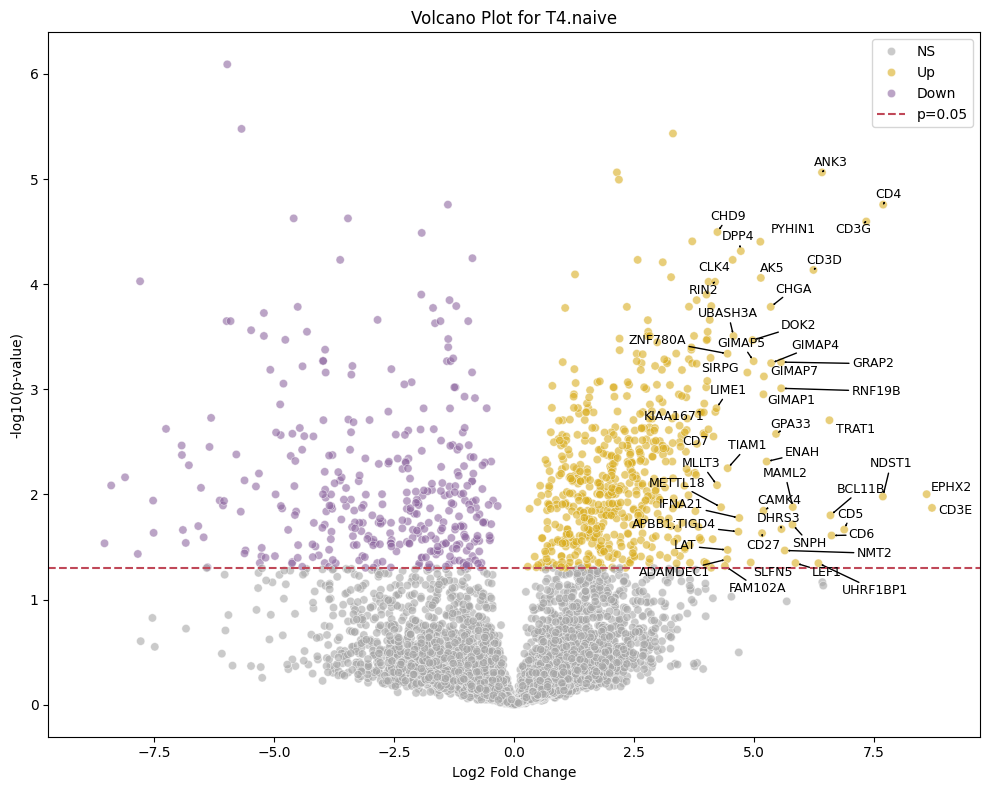

In [15]:
 # Custom color palette
palette = {'Up': '#daae21', 'Down': '#8e68a0', 'NS': '#a7a7a7'}        

# Limits for x-axis
x_lim =  abs(max(log_fold_changes)) + 1

# Create a volcano plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=results_df,
    x='Log2FoldChange',
    y=-np.log10(results_df['PAdjusted']),
    hue='Threshold',
    palette=palette,
    alpha=0.6
)

plt.axhline(-np.log10(0.05), color='#c04858', linestyle='--', label='p=0.05')

# Annotate the top molecules
texts = []
for i, row in selected_markers.iterrows():
    texts.append(plt.text(row['Log2FoldChange'], -np.log10(row['PAdjusted']),
        row['Marker'], fontsize=9, color='black', ha='center'))

# Adjust text to avoid overlaps
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='black'))
plt.xlim(-x_lim, x_lim)
plt.title(f'Volcano Plot for {group}')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-log10(p-value)')
plt.legend()
plt.tight_layout()
# plot_path = os.path.join(output_dir, f'volcano_{cell_type}.png')
# plt.savefig(plot_path)
# plt.close()
plt.show()

In [16]:
import yaml

# Save settings information
settings = {
    "data": expression_file_path,
    "populations": population_file_path,
    "n_markers": n_top_markers,
    "fc_threshold": FC_threshold,
    "pval_threshold": pval_threshold
}

param_file_path = os.path.join(res_path, "param.yaml")

with open(param_file_path, "w") as file:
    yaml.dump(settings, file)

## Marker Output

In [17]:
print(selected_markers)

           Marker  Log2FoldChange        PValue  PAdjusted Threshold  \
1312         CD3E        8.708194  7.917007e-04   0.013415        Up   
2592        EPHX2        8.596449  4.970442e-04   0.009939        Up   
1315          CD4        7.690569  1.374303e-08   0.000017        Up   
5239        NDST1        7.684030  5.409554e-04   0.010466        Up   
1314         CD3G        7.338311  2.948135e-08   0.000025        Up   
1322          CD5        6.879045  1.579989e-03   0.021580        Up   
1327          CD6        6.614680  1.871208e-03   0.024563        Up   
783        BCL11B        6.591629  1.021528e-03   0.015790        Up   
8556        TRAT1        6.571027  3.792903e-05   0.001967        Up   
349          ANK3        6.415757  4.571681e-09   0.000009        Up   
8868     UHRF1BP1        6.341214  4.387504e-03   0.045059        Up   
1311         CD3D        6.237945  1.705284e-07   0.000073        Up   
4319         LEF1        5.864003  4.347481e-03   0.044888      

## Running the program from terminal

In [21]:
# Help command to check the arguments

!python cellscribe.py --help



  █████  █████  ██     ██     ██████  ██████  █████   ███  █████  █████
 ██      ██     ██     ██     ██      ██      █   █    █   █   █  ██   
 ██      █████  ██     ██     ██████  ██      █████    █   █████  █████ 
 ██      ██     ██     ██         ██  ██      █  █     █   █   █  ██   
  █████  █████  █████  █████  ██████  ██████  █   █   ███  █████  █████


usage: cellscribe.py [-h] --data DATA --populations POPULATIONS
                     [--n_markers N_MARKERS] [--fc_threshold FC_THRESHOLD]
                     [--pval_threshold PVAL_THRESHOLD]
                     [--log2_transform LOG2_TRANSFORM]

CellScribe generates differential expression -based marker signatures for predetermined populations using expression data from high-throughput technologies such as mass spectrometry based proteomics, single-cell RNA sequencing or RNA sequencing.

options:
  -h, --help            show this help message and exit
  --data DATA           Path to the input expression matrix (csv). The fi

In [19]:
# Running CellScribe from command line with all arguments

!python cellscribe.py --data "data/proteins_subset.csv" --populations "data/sample_info.csv" --n_markers 40 --fc_threshold 0.5 --pval_threshold 0.07



  █████  █████  ██     ██     ██████  ██████  █████   ███  █████  █████
 ██      ██     ██     ██     ██      ██      █   █    █   █   █  ██   
 ██      █████  ██     ██     ██████  ██      █████    █   █████  █████ 
 ██      ██     ██     ██         ██  ██      █  █     █   █   █  ██   
  █████  █████  █████  █████  ██████  ██████  █   █   ███  █████  █████


File expression matrix read succesfully.
File populations read successfully.
All 'Label' values in 'populations' match column names in 'data'.
Signature results saved in: CellScribe_2025-02-03/signatures.csv



Generating signatures: 100%|██████████| 6/6 [02:22<00:00, 23.70s/Population]
